# Trial-1 

## Include Preprocessing (Normalization, CLAHE)

In [3]:
import os 
# from utils import Utils
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 
import skimage
from preprocessing import Preprocessing

# Utility Functions

In [4]:
def visualize_landmarks(image_path, landmarks_path, slice_index):
    """
    Visualize landmarks on a specific slice of a NIfTI image.

    Args:
        image_path (str): Path to the NIfTI image file.
        landmarks_path (str): Path to the landmarks text file.
        slice_index (int): The slice index to visualize.
    """
    # Load the NIfTI image
    img = nib.load(image_path)
    image = img.get_fdata()
    
    # Load the landmarks and ensure they are integers
    landmarks = np.loadtxt(landmarks_path).astype(int)
    
    # Plot the image and overlay landmarks
    plt.figure(figsize=(8, 8))
    plt.imshow(image[:, :, slice_index], cmap='gray')
    for x, y, z in landmarks:
        if z == slice_index: 
            plt.scatter(x, y, c='red', s=20, label='Landmark')
    plt.title(f'Slice {slice_index} with Landmarks')
    plt.axis('off')
    plt.legend(['Landmark'], loc='upper right')
    plt.show()
    
def parse_transformed_landmarks(file_path, export=False, export_dir=None):
    """
    Parse transformed landmarks from outputpoints.txt.

    Parameters:
        file_path (str): Path to the outputpoints.txt file.
        export (bool): If True, save the points serially to a text file.
        export_dir (str): Directory to save the exported file. 
                          If None, saves in the same directory as file_path.

    Returns:
        np.ndarray: Array of parsed landmark points.
    """
    points = []
    with open(file_path, 'r') as file:
        for line in file:
            if "OutputPoint" in line:
                # Extract coordinates from OutputPoint
                coords = line.split("OutputPoint = [")[1].split("]")[0]
                points.append(list(map(float, coords.split())))

    points_array = np.array(points)

    if export:
        # Extract the basename of the input file for naming
        basename = os.path.splitext(os.path.basename(file_path))[0]
        
        # Construct a descriptive file name
        export_file_name = f"{basename}_transformed_points.txt"
        
        # Define the export directory
        if export_dir is None:
            export_dir = os.path.dirname(file_path)
        
        # Ensure the export directory exists
        if not os.path.exists(export_dir):
            os.makedirs(export_dir)

        # Construct the full path for the export file
        export_file = os.path.join(export_dir, export_file_name)

        # Save the points serially to the export file
        with open(export_file, 'w') as out_file:
            for idx, point in enumerate(points_array, start=1):
                out_file.write(f"{idx}: {point[0]:.6f}, {point[1]:.6f}, {point[2]:.6f}\n")

    return points_array

def parse_original_landmarks(file_path):
    """Parse original landmarks from text files."""
    points = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip():
                # Extract coordinates
                coords = list(map(float, line.strip().split()))
                points.append(coords)
                points_np = np.array(points)
                points_np[:, 2] *= -1
    return points_np

def calculate_tre_mm(transformed_landmarks, original_landmarks, voxel_spacing):
    """
    Calculate Target Registration Error (TRE) in mm space.

    Args:
        transformed_landmarks (numpy.ndarray): Transformed landmarks (Nx3).
        original_landmarks (numpy.ndarray): Original landmarks (Nx3).
        voxel_spacing (tuple): Spacing of voxels in mm (x_spacing, y_spacing, z_spacing).

    Returns:
        # list: TRE for each point.
        float: Mean TRE.
    """
    # Apply voxel spacing to original landmarks
    scaled_original_landmarks = original_landmarks * np.array(voxel_spacing)
    # scaled_original_landmarks[:, 2] *= -1  # Invert z-axis
    scaled_transformed_landmarks = transformed_landmarks 
    # Calculate the Euclidean distances
    # distances = np.linalg.norm(scaled_transformed_landmarks - scaled_original_landmarks, axis=1)
    distances = np.sqrt(np.sum((scaled_original_landmarks - scaled_transformed_landmarks)**2 , axis=1))
    # Compute mean TRE
    mean_tre = np.mean(distances)
    # Compute standard deviation of TRE
    std_tre = np.std(distances)
    return mean_tre, std_tre

def apply_preprocessing(image):
    # Takes a SimpleITK image, applies preprocessing, and returns a SimpleITK image with the original metadata
    preprocessing = Preprocessing()
    
    # Extract metadata from the original image
    original_spacing = image.GetSpacing()
    original_origin = image.GetOrigin()
    original_direction = image.GetDirection()
    
    # Convert to NumPy array and preprocess
    data = sitk.GetArrayFromImage(image)
    data = preprocessing.preprocess(data)
    
    # Convert back to SimpleITK image
    processed_image = sitk.GetImageFromArray(data)
    
    # Restore the original metadata
    processed_image.SetSpacing(original_spacing)
    processed_image.SetOrigin(original_origin)
    processed_image.SetDirection(original_direction)
    
    return processed_image


def register_and_transform_images(
    fixed_image_path, moving_image_path, param_file_paths, output_dir, point_set_path, preprocessing=True):
    """
    Register images and apply transformations using SimpleITK.

    Parameters:
        fixed_image_path (str): Path to the fixed image.
        moving_image_path (str): Path to the moving image.
        param_file_paths (str or list of str): Path(s) to the parameter file(s). Can be a single file or a list of files.
        output_dir (str): Path to the output directory.
        point_set_path (str): Path to the point set file.

    Returns:
        tuple: Paths to the registered image file and transformed points file.
    """
    # Load images
    fixed_image = sitk.ReadImage(fixed_image_path)
    moving_image = sitk.ReadImage(moving_image_path)
    
    # Apply preprocessing 
    if preprocessing:
        fixed_image = apply_preprocessing(fixed_image)
        moving_image = apply_preprocessing(moving_image)

    # Extract the basename of the moving image for file naming
    basename = os.path.basename(moving_image_path).split(".")[0]

    # Set up ElastixImageFilter for registration
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_image)
    elastixImageFilter.SetMovingImage(moving_image)

    # Ensure param_file_paths is a list (to handle both single and multiple files)
    if isinstance(param_file_paths, str):
        param_file_paths = [param_file_paths]

    # Load the parameter files (can be single or multiple)
    parametervectormap = sitk.VectorOfParameterMap()
    for param_file_path in param_file_paths:
        paramater_file = sitk.ReadParameterFile(param_file_path)
        parametervectormap.append(paramater_file)
    
    elastixImageFilter.SetParameterMap(parametervectormap)

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set the output directory and execute the transformation
    elastixImageFilter.SetOutputDirectory(output_dir)
    elastixImageFilter.Execute()

    # Save the registered image with a descriptive name
    registered_image_path = os.path.join(output_dir, f"{basename}_reg.nii.gz")
    sitk.WriteImage(elastixImageFilter.GetResultImage(), registered_image_path)

    # Set up TransformixImageFilter for point transformation
    transform_param_map = elastixImageFilter.GetTransformParameterMap()
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(transform_param_map)
    transformixImageFilter.SetFixedPointSetFileName(point_set_path)
    transformixImageFilter.SetMovingImage(moving_image)  # Needed to infer dimensionality
    transformixImageFilter.SetOutputDirectory(output_dir)
    transformixImageFilter.Execute()

    # Save the transformed points file with a descriptive name
    transformed_points_file = os.path.join(output_dir, f"{basename}_transform.txt")

    # Rename the output points file to the new descriptive name
    original_points_file = os.path.join(output_dir, "outputpoints.txt")
    
    # Check if the target file exists and remove it
    if os.path.exists(transformed_points_file):
        os.remove(transformed_points_file)
    
    # Rename the file
    os.rename(original_points_file, transformed_points_file)

    return transformed_points_file

# Tesing if preprocessing is working or not 

In [15]:
copd1_in_path = 'dataset/copd1/copd1_iBHCT.nii.gz'

copd1_in_image = sitk.ReadImage(copd1_in_path)

copd1_in_image_processed = apply_preprocessing(copd1_in_image)

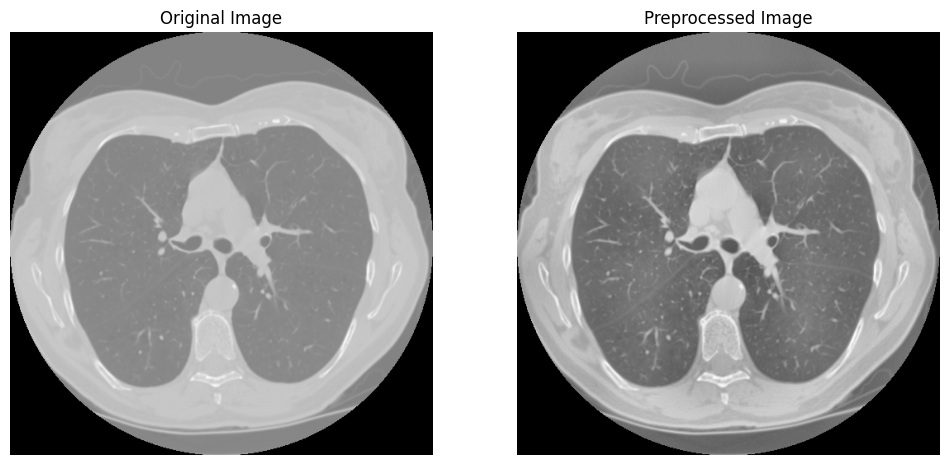

In [16]:
# Visualize the image before and after preprocessing
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(copd1_in_image)[50, :, :], cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(copd1_in_image_processed)[50, :, :], cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')
plt.show()

In [17]:
# Check the voxel spacing of the original image
print(f"Original Image Voxel Spacing: {copd1_in_image.GetSpacing()}")
# Check the voxel spacing of the preprocessed image
print(f"Preprocessed Image Voxel Spacing: {copd1_in_image_processed.GetSpacing()}")

Original Image Voxel Spacing: (0.6200000047683716, 0.6200000047683716, 2.5)
Preprocessed Image Voxel Spacing: (0.6200000047683716, 0.6200000047683716, 2.5)


# Registration and Results

In [5]:
# Base directory and parameter file path
base_dir = "dataset"
param_file_path_affine = 'Parameter_Files/Parameters.Par0011.affine.txt'
param_file_path = "Parameter_Files/Parameters.Par0011.bspline1_s.txt"
subdirs = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

voxel_spacing_map = {
    "copd1": (0.62, 0.62, 2.5),
    "copd2": (0.64, 0.64, 2.5),
    "copd3": (0.65, 0.65, 2.5),
    "copd4": (0.59, 0.59, 2.5),
    "copd5": (0.65, 0.65, 2.5),
    "copd6": (0.63, 0.63, 2.5),
    "copd7": (0.62, 0.62, 2.5),
    "copd8": (0.59, 0.59, 2.5),
    "copd9": (0.66, 0.66, 2.5),
    "copd10": (0.74, 0.74, 2.5),
}

for subdir in subdirs:
    overall_mean_tre = []
    overall_std_tre = []
    input_dir = os.path.join(base_dir, subdir)
    fixed_image_path = os.path.join(input_dir, f"{subdir}_iBHCT.nii.gz")
    moving_image_path = os.path.join(input_dir, f"{subdir}_eBHCT.nii.gz")
    output_dir = os.path.join(input_dir, "reg_result", "transform_params")
    fixed_point_path = os.path.join(input_dir, f"{subdir}_300_iBH_xyz_r1.pts")
    landmarks_ex_path = os.path.join(input_dir, f"{subdir}_300_eBH_xyz_r1.txt")

    voxel_spacing = voxel_spacing_map.get(subdir)
    if voxel_spacing is None:
        raise ValueError(f"Voxel spacing for {subdir} not found in voxel_spacing_map.")

    # Register and transform images
    transformed_points_file = register_and_transform_images(
        fixed_image_path, moving_image_path, [param_file_path_affine, param_file_path], output_dir, fixed_point_path
    )

    # Parse the landmarks
    transformed_points = parse_transformed_landmarks(transformed_points_file)
    original_points_exhale = parse_original_landmarks(landmarks_ex_path)

    # Compute TRE for inhale and exhale landmarks
    mean_tre, std_tre = calculate_tre_mm(
        transformed_points, original_points_exhale, voxel_spacing=voxel_spacing
    )
    overall_mean_tre.append(mean_tre)
    overall_std_tre.append(std_tre)
        
    print(f"Directory: {subdir}")
    print("Mean TRE:", mean_tre)
    print("Std TRE:", std_tre)

print("Overall Mean TRE:", np.mean(overall_mean_tre))
print("Overall Std TRE:", np.mean(overall_std_tre))

Directory: copd1
Mean TRE: 7.328055724719013
Std TRE: 5.687916284644145
Directory: copd2
Mean TRE: 8.27023722104657
Std TRE: 6.386332081430051
Directory: copd3
Mean TRE: 3.7221809583428254
Std TRE: 2.6361364210036444
Directory: copd4
Mean TRE: 5.433269801205569
Std TRE: 3.759613282425686
Overall Mean TRE: 5.433269801205569
Overall Std TRE: 3.759613282425686
